# Predict Titanic Survival

The main goal is to pre-process the data as good as you can, select the right techniques and obtain a good score. The main idea behind the competition is to come
up with a model to predict whether someone survived the Titanic disaster or not based on a training set of people for whom you know whether they survived or not.

# Exploration phase

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [4]:
# Initialize dataframe
df = pd.read_csv('./data/train.csv')
# Show first 5 rows
df.head()
# Survived is target label, 0 = deceased and 1 = survived

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Text(0.5, 1.0, 'Visual demonstration of missing values in "training" dataset')

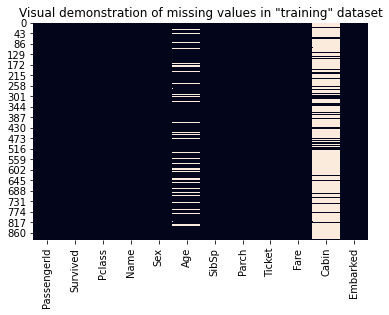

In [5]:
"""This could be used to visually demonstrate (in the report) how important it was to predict the age groups of passangers."""
sns.heatmap(df.isnull(), cbar = False).set_title('Visual demonstration of missing values in "training" dataset')


In [6]:
print('Total rows: {}'.format(df.shape[0]))

Total rows: 891


In [7]:
print('Missing values:')
print(df.isna().sum())

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
print('Unique values per feature:')
print(df.nunique())

Unique values per feature:
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [9]:
# Data cleanup (should be seperate function eventually)

# Function from https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    print(big_string)
    return np.nan

def data_cleanup(df):
    # Drop PassengerID
    df = df.drop(['PassengerId'],axis=1)

    # name turn to title
    # coded with help of https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
    # ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Mlle', 'Col' 'Capt' 'Countess' 'Jonkheer']
    # [11 12  8  7  3 14  4 10 13  6  9  1  0  2  5]
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
    # Title will be turned into unique label integer
    df['Title'] = LabelEncoder().fit_transform(df['Title'])
    # Name will be dropped 
    df = df.drop(['Name'],axis=1)

    # Sex should be turned into unique integer label, 0 or 1
    # Sex, 0 = female and 1 = male
    df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

    # ticket (Ticket number) not sure if this is very informative? Suggestion to drop it (Pclass and fare are more informative)
    df = df.drop(['Ticket'],axis=1)

    # cabin (number), 687 missing values (77%). I suggest leaving this feature out, due to its absence in training set (Pclass and fare might depict what kind of cabin better)
    df = df.drop(['Cabin'],axis=1)

    # embarked should be turned into unique integer label, 0 = C (Cherbourgh), 1 = Q (Queenstown), 2 = S (Southampton)
    df.Embarked.fillna('C', inplace=True)
    df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
    return df

df = data_cleanup(df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,11
1,1,1,0,38.0,1,0,71.2833,0,12
2,1,3,0,26.0,0,0,7.9250,2,8
3,1,1,0,35.0,1,0,53.1000,2,12
4,0,3,1,35.0,0,0,8.0500,2,11


In [10]:
# Print amount males and females
print(df.Sex.value_counts())
# Sex, 0 = female and 1 = male

1    577
0    314
Name: Sex, dtype: int64


Sex  Survived
0    1           233
     0            81
1    0           468
     1           109
Name: Survived, dtype: int64


<AxesSubplot:xlabel='Sex'>

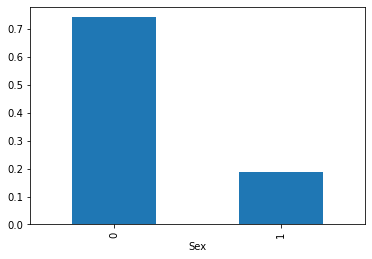

In [11]:
# Relation male/female and survived
print(df.groupby('Sex').Survived.value_counts())
df.groupby('Sex').Survived.mean().plot(kind='bar')
# Survived is target label, 0 = deceased and 1 = survived
# Sex, 0 = female and 1 = male

In [12]:
# Plot fare
print(df['Fare'].describe())

print(df.loc[df['Fare'] == 0])
print(df.loc[df['Fare'] == 0].size)

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
     Survived  Pclass  Sex   Age  SibSp  Parch  Fare  Embarked  Title
179         0       3    1  36.0      0      0   0.0         2     11
263         0       1    1  40.0      0      0   0.0         2     11
271         1       3    1  25.0      0      0   0.0         2     11
277         0       2    1   NaN      0      0   0.0         2     11
302         0       3    1  19.0      0      0   0.0         2     11
413         0       2    1   NaN      0      0   0.0         2     11
466         0       2    1   NaN      0      0   0.0         2     11
481         0       2    1   NaN      0      0   0.0         2     11
597         0       3    1  49.0      0      0   0.0         2     11
633         0       1    1   NaN      0      0   0.0         2     11
674         0       2    1   NaN      0    

In [13]:
# AGE PREDICTOR EXPERIMENT
df_1 = pd.read_csv('./data/train.csv')
df_2 = pd.read_csv('./data/test.csv')

# Ready df_1
df_1 = df_1.loc[df_1.Age.notnull()]
df_1.drop(['Survived'],axis=1, inplace=True)
df_1 = data_cleanup(df_1)
print(df_1.shape[0])
# Ready df_2
df_2 = df_2.loc[df_2.Age.notnull()]
df_2 = df_2.loc[df_2.Fare.notnull()]
df_2 = data_cleanup(df_2)
print(df_2.shape[0])

new_df = pd.concat([df_1, df_2], axis=0)

print(new_df.head())
print(new_df.shape[0])

print('Unique values per feature:')
print(new_df.nunique())

print('Missing values:')
print(new_df.isna().sum())

new_df.corr(method='pearson')


714
331
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title
0       3    1  22.0      1      0   7.2500         2     11
1       1    0  38.0      1      0  71.2833         0     12
2       3    0  26.0      0      0   7.9250         2      8
3       1    0  35.0      1      0  53.1000         2     12
4       3    1  35.0      0      0   8.0500         2     11
1045
Unique values per feature:
Pclass        3
Sex           2
Age          97
SibSp         7
Parch         7
Fare        256
Embarked      3
Title        15
dtype: int64
Missing values:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
Pclass,1.000000,0.144105,-0.411086,0.047746,0.017685,-0.565255,0.280274,0.056142
Sex,0.144105,1.000000,0.062235,-0.094902,-0.220864,-0.187930,0.113614,0.095851
Age,-0.411086,0.062235,1.000000,-0.243139,-0.150241,0.178740,-0.087878,0.158041
SibSp,0.047746,-0.094902,-0.243139,1.000000,0.374291,0.141184,0.047351,-0.090327
Parch,0.017685,-0.220864,-0.150241,0.374291,1.000000,0.216723,0.013017,-0.040694
Fare,-0.565255,-0.187930,0.178740,0.141184,0.216723,1.000000,-0.303069,-0.086668
Embarked,0.280274,0.113614,-0.087878,0.047351,0.013017,-0.303069,1.000000,0.100735
Title,0.056142,0.095851,0.158041,-0.090327,-0.040694,-0.086668,0.100735,1.000000


count    1045.000000
mean       29.851837
std        14.389194
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


<AxesSubplot:>

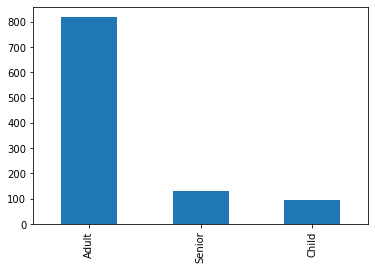

In [14]:
# According to the correlation schema, correlation between Age and Sex/Embarked is negligble so leaving them out
new_df.drop(['Embarked', 'Sex'],axis=1, inplace=True)
# Describe Age ranges
print(new_df['Age'].describe())

# Age groups, need to figure out class balance 
bins= [0, 13, 48, 110]
labels = ['Child', 'Adult', 'Senior']
new_df['AgeGroup'] = pd.cut(new_df['Age'], bins=bins, labels=labels, right=False)

new_df['AgeGroup'].value_counts().plot(kind='bar')

In [15]:
new_df.head()

,Pclass,Age,SibSp,Parch,Fare,Title,AgeGroup
0,3,22.0,1,0,7.2500,11,Adult
1,1,38.0,1,0,71.2833,12,Adult
2,3,26.0,0,0,7.9250,8,Adult
3,1,35.0,1,0,53.1000,12,Adult
4,3,35.0,0,0,8.0500,11,Adult


In [16]:
# Evaluating two models, CategoricalNaiveBayes and CategoricalDecisionTree - EVALUATED, chosen for RandomForestClassifier

# First drop age
new_df.drop(['Age'],axis=1, inplace=True)
# Turn AgeGroup into unique label integer
print(new_df['AgeGroup'].unique())
new_df['AgeGroup'] = LabelEncoder().fit_transform(new_df['AgeGroup'])
print(new_df['AgeGroup'].unique())
# Double check df
print(new_df.head())

# Preparing data 
X_exp = new_df.iloc[:,0:5] 
y_exp = new_df.iloc[:, 5]
X_exp.head(), y_exp.head()

# To counteract the class imbalance

# Random oversampler
ros = RandomOverSampler(random_state=0)
X_exp, y_exp = ros.fit_resample(X_exp, y_exp)
# SMOTE oversampler
# smote = SMOTE()
# X_exp, y_exp = smote.fit_resample(X_exp, y_exp)

# Initialize models
rfc_e = RandomForestClassifier(criterion='entropy')
rfc_g = RandomForestClassifier(criterion='gini')
# cnb = CategoricalNB(min_categories=X_exp.nunique() + 2)


['Adult', 'Senior', 'Child']
Categories (3, object): ['Child' < 'Adult' < 'Senior']
[0 2 1]
   Pclass  SibSp  Parch     Fare  Title  AgeGroup
0       3      1      0   7.2500     11         0
1       1      1      0  71.2833     12         0
2       3      0      0   7.9250      8         0
3       1      1      0  53.1000     12         0
4       3      0      0   8.0500     11         0


In [17]:
# Cross-validate (stratified k fold) scores each model
scores_rfc_e = cross_val_score(rfc_e, X_exp, y_exp, cv=5)
scores_rfc_g = cross_val_score(rfc_g, X_exp, y_exp, cv=5)
# scores_cnb = cross_val_score(cnb, X_exp, y_exp, cv=5)

print("rfc_e %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_e.mean(), scores_rfc_e.std()))
print("rfc_g %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_g.mean(), scores_rfc_g.std()))
# print("cnb %0.2f accuracy with a standard deviation of %0.2f" % (scores_cnb.mean(), scores_cnb.std()))

pred_rfc_e = cross_val_predict(rfc_e, X_exp, y_exp, cv=5)
pred_rfc_g = cross_val_predict(rfc_g, X_exp, y_exp, cv=5)
# pred_cnb = cross_val_predict(cnb, X_exp, y_exp, cv=5)

print(classification_report(y_exp, pred_rfc_e))
#ConfusionMatrixDisplay.from_predictions(y_exp, pred_rfc_e)

print(classification_report(y_exp, pred_rfc_g))
#ConfusionMatrixDisplay.from_predictions(y_exp, pred_rfc_g)

# print(classification_report(y_exp, pred_cnb))
# ConfusionMatrixDisplay.from_predictions(y_exp, pred_cnb)


rfc_e 0.89 accuracy with a standard deviation of 0.03
rfc_g 0.89 accuracy with a standard deviation of 0.03
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       819
           1       0.97      1.00      0.98       819
           2       0.81      0.92      0.86       819

    accuracy                           0.89      2457
   macro avg       0.89      0.89      0.89      2457
weighted avg       0.89      0.89      0.89      2457

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       819
           1       0.97      1.00      0.98       819
           2       0.80      0.92      0.86       819

    accuracy                           0.89      2457
   macro avg       0.89      0.89      0.88      2457
weighted avg       0.89      0.89      0.88      2457



In [18]:
# Show rows of original train df that does not have age
ageless_df = df[df['Age'].isnull()]
ageless_df.drop(['Survived', 'Embarked', 'Sex', 'Age'],axis=1, inplace=True)
print(ageless_df.tail())
# Fit chosen model with our data
rfc_g.fit(X_exp, y_exp)
# Predict 
predict_age = rfc_g.predict(ageless_df)

print(predict_age)
print(ageless_df.index)


     Pclass  SibSp  Parch     Fare  Title
859       3      0      0   7.2292     11
863       3      8      2  69.5500      8
868       3      0      0   9.5000     11
878       3      0      0   7.8958     11
888       3      1      2  23.4500      8
[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 2 0 2 2 0 0 0 2 2 1 0 0 0 0 0 2 1 0 0
 2 0 2 0 0 0 0 1 0 0 0 0 2 2 0 0 0 2 2 0 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 1 0 0 2 0 0 0 2 0 0 0 2 0 2 2 2 0 0 0 2 1 0 0 0 0 2 2 0 0 0 0 0 0
 0 2 2 0 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 2 0
 0 2 0 0 2 0 0 0 0 2 0 0 2 0 2 0 0 0 2 0 2 2 0 0 0 0 0 0 1]
Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)


C:\Users\Konstantin\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
# Plug values into df
print(type(predict_age))
df.loc[ageless_df.index, 'AgeGroup'] = predict_age
# print(df.loc[ageless_df.index])
# Turn existing ages into agegroups
bins= [0, 13, 48, 110]
labels = [0, 2, 1]

m = df['AgeGroup'].isna()
df.loc[m, 'AgeGroup'] = pd.cut(df[df['AgeGroup'].isnull()]['Age'], bins=bins, labels=labels, right=False).to_numpy()
df['AgeGroup'] = df['AgeGroup'].astype(int)
# Drop the Age feature
df.drop(['Age'],axis=1, inplace=True)
print(df)

<class 'numpy.ndarray'>
     Survived  Pclass  Sex  SibSp  Parch     Fare  Embarked  Title  AgeGroup
0           0       3    1      1      0   7.2500         2     11         2
1           1       1    0      1      0  71.2833         0     12         2
2           1       3    0      0      0   7.9250         2      8         2
3           1       1    0      1      0  53.1000         2     12         2
4           0       3    1      0      0   8.0500         2     11         2
..        ...     ...  ...    ...    ...      ...       ...    ...       ...
886         0       2    1      0      0  13.0000         2     14         2
887         1       1    0      0      0  30.0000         2      8         2
888         0       3    0      1      2  23.4500         2      8         1
889         1       1    1      0      0  30.0000         0     11         2
890         0       3    1      0      0   7.7500         1     11         2

[891 rows x 9 columns]


# Working on it from here, fill up later

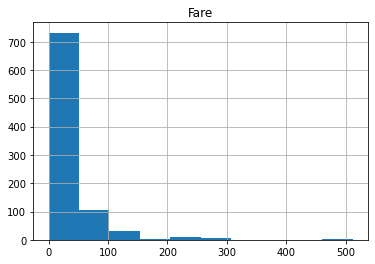

In [20]:
fare_dist = df.hist('Fare')
# think on this later, can something useful be done for the fare feature?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int32  
 7   Title     891 non-null    int32  
 8   AgeGroup  891 non-null    int32  
dtypes: float64(1), int32(4), int64(4)
memory usage: 48.9 KB
None


<AxesSubplot:>

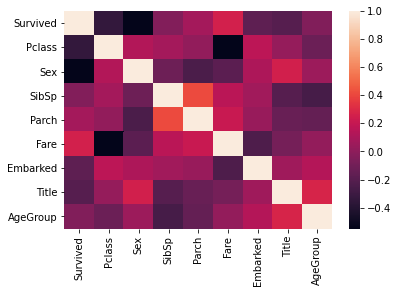

In [21]:
print(df.info())
sns.heatmap(df.corr())

In [22]:
"""Displays the average price paid, family size and number of siblings for both not survived(0) and survived(1). """

pd.pivot_table(df, index= 'Survived', values = ['SibSp', 'Parch', 'Fare'])

# Nothing here is too significant, but:
# This indicates that those who survived payed more
# those who have parents are more likely to survive
# those who have siblings are less likely to survive? 
# I dont think this is too surprising

,Fare,Parch,SibSp
Survived,,,
0,22.117887,0.329690,0.553734
1,48.395408,0.464912,0.473684


## Visualising currently remaining features

<AxesSubplot:title={'center':'How many survived'}>

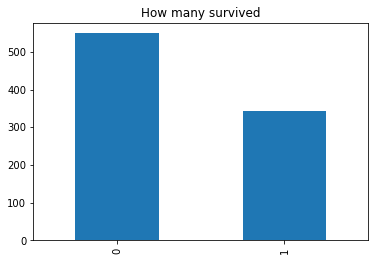

In [23]:
df['Survived'].value_counts().plot.bar(title='How many survived')#####2@@@dfgdfgdfgdfgdfgasdghjghjfghgfhi

<AxesSubplot:title={'center':'How many in each class'}>

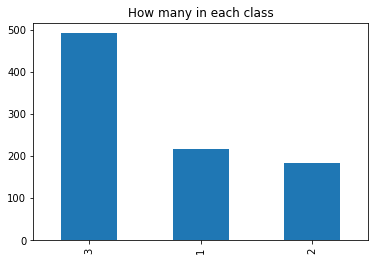

In [24]:
df['Pclass'].value_counts().plot.bar(title='How many in each class')

<AxesSubplot:title={'center':'How many siblings and spouses'}>

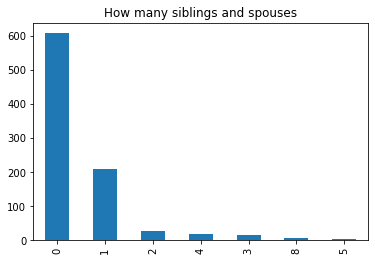

In [25]:
df['SibSp'].value_counts().plot.bar(title='How many siblings and spouses')

<AxesSubplot:title={'center':'How many with parent or children a passanger has'}>

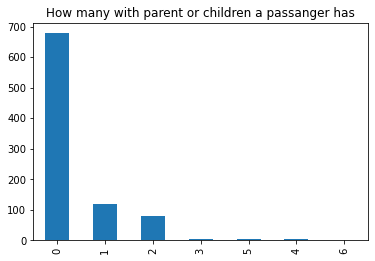

In [26]:
df['Parch'].value_counts().plot.bar(title='How many with parent or children a passanger has')

### Representing how many survived from each class

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

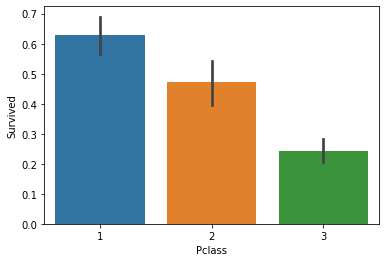

In [27]:
sns.barplot(x='Pclass', y='Survived', data=df)

### For write up - This strongly indicates that survival rates were highly dependant on the passangers class. 

C:\Users\Konstantin\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


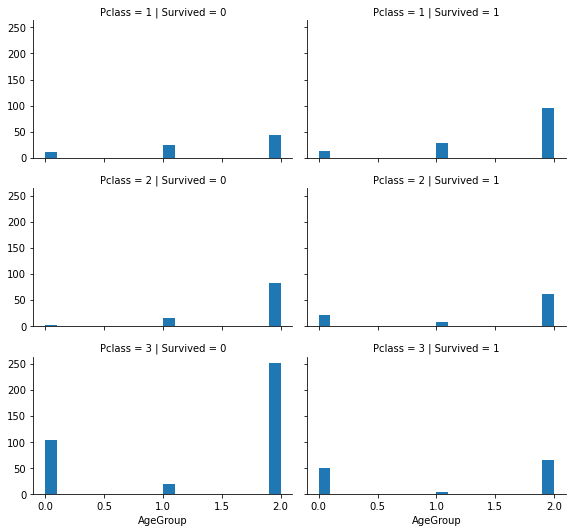

In [28]:
"""The plot below further demonstrates that 1st class passangers were more likely to survive while 3rd class passangers were less likely to survive"""


### ['Child', 'Adult', 'Senior'] are [0, 2, 1]

grid = sns.FacetGrid(df, col='Survived', row='Pclass', size=2.5, aspect=1.6)
grid.map(plt.hist, 'AgeGroup', alpha=1, bins=20)
grid.add_legend()

# Preprocessing
### Combining Siblings/spouses and Parents/childern features to 'Family' column and making an 'alone' category

1    537
0    354
Name: Alone, dtype: int64


C:\Users\Konstantin\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


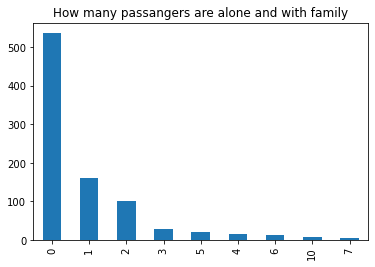

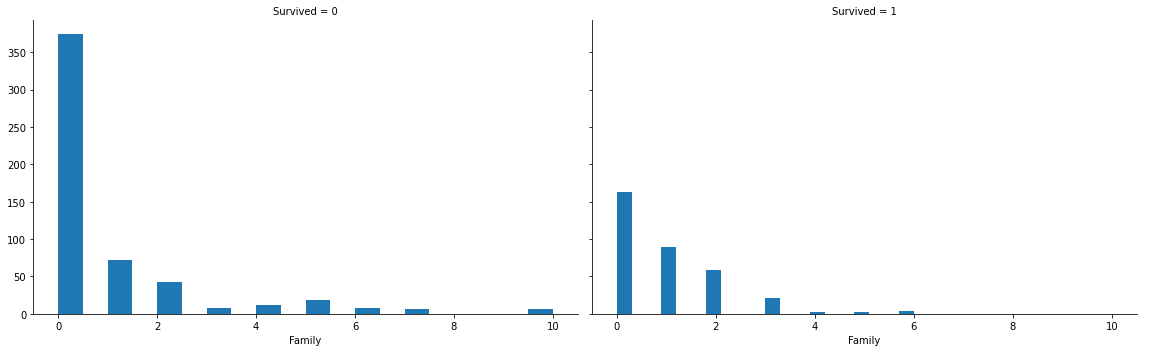

In [29]:
# Making family column with both Parch and SibSp
df['Family'] = df['Parch'] + df['SibSp']

# Making alone category where Family column is 0 and then replacing the booleans with ints 
df['Alone'] = df['Family'] == 0
df['Alone'].replace({False: 0, True: 1}, inplace=True)

# How many in Family and Alone [1=is alone, 0=has family]
print(df['Alone'].value_counts())

# Displaying family sizes
df['Family'].value_counts().plot.bar(title='How many passangers are alone and with family')


# Displaying survivability with family amount, It seems like passangers with < 3 family members are more likely to survive
grid = sns.FacetGrid(df, col='Survived', size=5, aspect=1.6)
grid.map(plt.hist, 'Family', alpha=1, bins=20)
grid.add_legend()

# Dropping both Parch and SibSp columns from df
df = df.drop(['Parch'], axis=1)
df = df.drop(['SibSp'], axis=1)



### To Consider: Should we do something quickly about the fare feature? Turn into categories maybe? 

In [30]:
display(df)
df.info()


,Survived,Pclass,Sex,Fare,Embarked,Title,AgeGroup,Family,Alone
0,0,3,1,7.2500,2,11,2,1,0
1,1,1,0,71.2833,0,12,2,1,0
2,1,3,0,7.9250,2,8,2,0,1
3,1,1,0,53.1000,2,12,2,1,0
4,0,3,1,8.0500,2,11,2,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,1,13.0000,2,14,2,0,1
887,1,1,0,30.0000,2,8,2,0,1
888,0,3,0,23.4500,2,8,1,3,0
889,1,1,1,30.0000,0,11,2,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Fare      891 non-null    float64
 4   Embarked  891 non-null    int32  
 5   Title     891 non-null    int32  
 6   AgeGroup  891 non-null    int32  
 7   Family    891 non-null    int64  
 8   Alone     891 non-null    int64  
dtypes: float64(1), int32(4), int64(4)
memory usage: 48.9 KB


### Preparing the data 

In [64]:
# Load in the test.csv
test_df = pd.read_csv('./data/test.csv')
# test = test_df.drop('PassengerId', axis=1) # to avoid error

X_training = df.iloc[:,1:9] 
y_training = df['Survived']

# Train test split - 
###The train-test split procedure is used to estimate the performance of machine learning algorithms 
### when they are used to make predictions on data not used to train the model.
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Initializing the models

In [36]:
# Random Forest 
rfc_e_end = RandomForestClassifier(criterion='entropy')
rfc_g_end = RandomForestClassifier(criterion='gini')
# Stochastic Gradient Descent
sgd = SGDClassifier()
# Gaussian Naive Bayes
gnb = GaussianNB()

### Running the models

In [44]:
### Gaussian Naive Bayes 
gnb_res = cross_val_score(gnb, X_training, y_training)
print(gnb_res)
print(f"gnb {gnb_res.mean()} accuracy with standard diviation of {gnb_res.std()}")

gnb_pred = gnb.predict(X_val)
print(f"gnb accuracy score is : {accuracy_score(y_val, gnb_pred)}")

[0.74860335 0.78089888 0.7752809  0.82022472 0.81460674]
gnb 0.7879229175820727 accuracy with standard diviation of 0.026497618295435687
gnb accuracy score is : 0.7982062780269058


In [77]:
### Random Forest Classification
scores_rfc_e_end = cross_val_score(rfc_e_end, X_training, y_training, cv=5)
scores_rfc_g_end = cross_val_score(rfc_g_end, X_training, y_training, cv=5)

print(scores_rfc_e_end)
print(scores_rfc_g_end)
print("rfc_e %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_e_end.mean(), scores_rfc_e_end.std()))
print("rfc_g %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_g_end.mean(), scores_rfc_g_end.std()))

rfc_e_end.fit(X_training, y_training)
rfc_e_pred = rfc_e_end.predict(X_val)
print(f"rfc_e accuracy score is : {accuracy_score(y_val, rfc_e_pred)}")

rfc_g_end.fit(X_training, y_training)
rfc_g_pred = rfc_g_end.predict(X_val)
print(f"rfc_g accuracy score is : {accuracy_score(y_val, rfc_e_pred)}")



[0.7877095  0.7752809  0.84269663 0.76966292 0.83146067]
[0.79888268 0.76966292 0.85393258 0.78089888 0.83146067]
rfc_e 0.80 accuracy with a standard deviation of 0.03
rfc_g 0.81 accuracy with a standard deviation of 0.03
rfc_e accuracy score is : 0.9237668161434978
rfc_g accuracy score is : 0.9237668161434978


In [61]:
### Stochastic Gradient Descent
sgd_scores = cross_val_score(sgd, X_training, y_training)
print(sgd_scores)
print(f"sgd {sgd_scores.mean()} accuracy with standard diviation of {sgd_scores.std()}")

sgd.fit(X_training, y_training)
sgd_pred = sgd.predict(X_val)
print(f"sgd accuracy score is : {accuracy_score(y_val, sgd_pred)}")
print(sgd.score(X_training, y_training))


[0.68156425 0.57865169 0.61797753 0.80898876 0.61235955]
sgd 0.6599083547799885 accuracy with standard diviation of 0.08162802873061702
sgd accuracy score is : 0.6816143497757847
0.7115600448933782


In [71]:
### Table of results

table_res = pd.DataFrame({'Scores for models:': [gnb_res.mean(), scores_rfc_e_end.mean(), scores_rfc_g_end.mean(), sgd_scores.mean()], 
                            'Models': ['Gaussian Naive Bayes', 'Random Forest Classification (Entropy)', 'Random Forest Classification (Gini)', 'Stochastic Gradient Descent']})

display(table_res)

,Scores for models:,Models
0,0.787923,Gaussian Naive Bayes
1,0.806974,Random Forest Classification (Entropy)
2,0.795750,Random Forest Classification (Gini)
3,0.659908,Stochastic Gradient Descent


<BarContainer object of 8 artists>

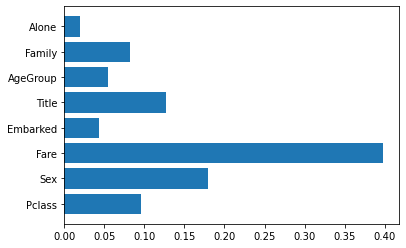

In [76]:
### barchart of Importance
# Show importances of features, (checks by what do each tree break into nodes), 

plt.barh(X_training.columns, rfc_e_end.feature_importances_)